In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler, Estimator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, Operator, random_unitary, random_density_matrix
from qiskit.circuit.library import CXGate, CZGate, IGate, HGate, XGate, YGate
from qiskit.quantum_info import entanglement_of_formation


import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

In [9]:
# prepare bell state
bell00 = QuantumCircuit(2)
bell00.h(0)
bell00.cx(0, 1)

bell01 = bell00.copy()
bell01.z(0)

bell10 = bell00.copy()
bell10.x(0)

bell11 = bell00.copy()
bell11.x(0)
bell11.z(0)

bell_meas = bell00.copy().inverse()

bell00 = DensityMatrix.from_instruction(bell00)
bell01 = DensityMatrix.from_instruction(bell01)
bell10 = DensityMatrix.from_instruction(bell10)
bell11 = DensityMatrix.from_instruction(bell11)

display(bell00.reverse_qargs().draw('latex'))
display(bell01.reverse_qargs().draw('latex'))
display(bell10.reverse_qargs().draw('latex'))
display(bell11.reverse_qargs().draw('latex'))



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [10]:
class BellEntanglementPurification(object):
    CC = Operator.from_label('00') + Operator.from_label('11')
    ECC = Operator.from_label('II').expand(CC)

    def __init__(self, mixed_state:DensityMatrix) -> None:
        super().__init__()
        self.initial_state = mixed_state
        self.state = mixed_state.copy()
        self.log_yield_list = []

    def step(self, twirl:Operator=None, flag=False):
        if twirl is None:
            state = self.state
        else:
            state = self.state.evolve(twirl.expand(twirl.conjugate()))
        if flag:
            state = state.evolve(HGate(), qargs=[0])
            state = state.evolve(HGate(), qargs=[1])
        state = self.bxor(state, state) # Bidirectional XOR
        if flag:
            state = state.evolve(HGate(), qargs=[0])
            state = state.evolve(HGate(), qargs=[1])
            state = state.evolve(HGate(), qargs=[2])
            state = state.evolve(HGate(), qargs=[3])
        state = partial_trace(state.evolve(self.ECC), [2, 3]) # post selection
        prob = state.trace()
        self.log_yield_list.append(np.log2(prob/2))
        self.state = state/prob

    @staticmethod
    def bxor(source:DensityMatrix, target:DensityMatrix):
        state = source.expand(target)
        state = state.evolve(CXGate(), qargs=[0, 2])
        state = state.evolve(CXGate(), qargs=[1, 3])
        return state
    
    @staticmethod
    def bphase(source:DensityMatrix, target:DensityMatrix):
        state = source.expand(target)
        state = state.evolve(CZGate(), qargs=[0, 2])
        state = state.evolve(CZGate(), qargs=[1, 3])
        return state

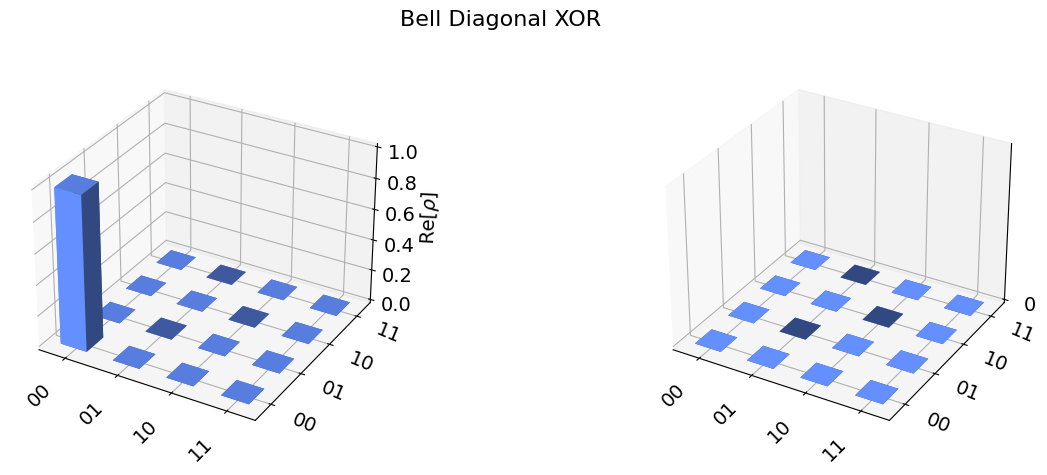

In [11]:
mixed_state = 0.51*bell00 + 0.4*bell11 + 0.00*bell01 + 0.09*bell10
eof_list_wt = []
eof_list_wot = []
purifier1 = BellEntanglementPurification(mixed_state)
purifier2 = BellEntanglementPurification(mixed_state)
for i in range(50):
    purifier1.step(twirl=random_unitary(2), flag=False)
    purifier2.step(twirl=None, flag=False)
    eof_list_wt.append(entanglement_of_formation(purifier1.state))
    eof_list_wot.append(entanglement_of_formation(purifier2.state))

plot_state_city(purifier2.state.evolve(bell_meas), title='Bell Diagonal XOR')

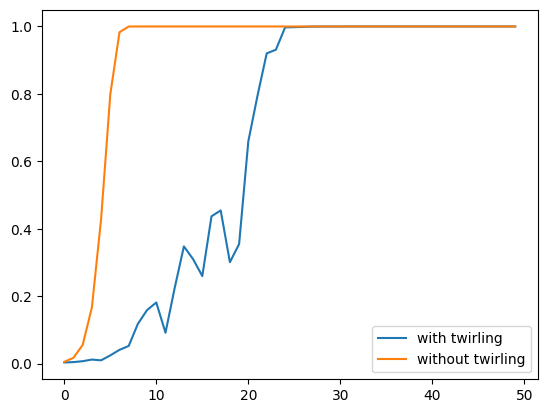

In [12]:
plt.plot(eof_list_wt, label='with twirling')
plt.plot(eof_list_wot, label='without twirling')
plt.legend()

In [13]:
source = bell01
target = bell10
state = BellEntanglementPurification.bphase(source, target)
new_source = partial_trace(state, [2, 3])
new_target = partial_trace(state, [0, 1])
display(new_source.draw('latex'))
display(new_target.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [14]:
bell11.evolve(Operator(XGate()).expand(Operator(YGate()))).draw('latex')

<IPython.core.display.Latex object>

In [16]:
-8/3-np.log2(3)/3*2

-3.7233083338141038